# Pytorch 实现VAE(Variational Auto-Encoder,变分自编码器)
VAE是一种基于自编码器的深度**生成**模型

根据[博客](https://adaning.github.io/posts/53598.html)进行学习

# 理论知识
## AE(Auto-Encoder)
![AE(Auto-Encoder)](img/2022-10-11-18-01-58.png)

传统的自编码器可以分为Encoder和Decoder两个部分,但是实际上Encoder和Decoder并不能单独独立使用,因为中间层的Code并非是呈现一定的规律性.

## VAE
### 隐变量-概率分布式
理想形态下 生成模型可以被表述为$X=g(Z)$,但是由于没法直接知道$p(X)$,我们需要引入隐变量$Z$来求:
$$p(X) = \sum_Z p(X\mid Z) p(Z)$$
如果我们能把输入样本X编码得到的Z,即隐变量控制在某个分布中,我们就可以从隐变量的分布中采样,直接解码得到生成的结果,让Decoder独立工作,此时需要将隐变量建模为概率分布,而非是像AE一样看作是一个离散的值.
![VAE和AE在隐变量建模上的区别](img/2022-10-11-18-20-51.png)
每个样本都有一个自己专属的正态分布,样本之间必定存在重合,当采样到两个样本的叠加区域时,解码的内容会介于二者之间,例如满月到半月之间
![](img/2022-10-11-20-09-10.png)

每个分布的均值和方差需要通过神经网络直接拟合样本对应的正态分布$均值\mu和方差\sigma^2$
![](img/2022-10-11-20-10-53.png)
<!-- 在实际情况中,我们拟合的是$log \sigma^2$ -->

### KL散度-防止神经网络偷懒

在VAE任务中,一定要限制网络将方差学为0,这样就会把样本学成了一个点(离散值),导致VAE退化成AE.
我们使用KL散度来约束$p(Z|X)$,令其服从标准正态分布
> KL散度(KL Divergence,相对熵)用于衡量两个分布之间的差异性(信息损失),
> 假设P为真实的样本分布,Q为模型预测的分布,根据KL散度的公式formula:
> $$D_{\mathrm{KL}}(P \| Q)=\mathbb{E}_{\mathrm{x} \sim P}\left[\log \frac{P(x)}{Q(x)}\right]=\mathbb{E}_{\mathrm{x} \sim P}[\log P(x)-\log Q(x)]$$
> 当P,Q越接近时,$D_{\mathrm{KL}}$越小,当且仅当P和Q完全相同时,值为0
> KL散度还有两个性质
> 1. 非负
> 2. 不对称

求解过程如下:
$$
\begin{aligned}
&KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)\\
=&\int \frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/2\sigma^2} \left(\log \frac{e^{-(x-\mu)^2/2\sigma^2}/\sqrt{2\pi\sigma^2}}{e^{-x^2/2}/\sqrt{2\pi}}\right)dx\\\
=&\int \frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/2\sigma^2} \log \left\{\frac{1}{\sqrt{\sigma^2}}\exp\left\{\frac{1}{2}\big[x^2-(x-\mu)^2/\sigma^2\big]\right\} \right\}dx\\\
=&\frac{1}{2}\int \frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/2\sigma^2} \Big[-\log \sigma^2+x^2-(x-\mu)^2/\sigma^2 \Big] dx \\
=&\frac{1}{2}(-\log\sigma^2+\mu^2+\sigma^2-1)
\end{aligned}
$$
在求解时,需要Minimize Dkl
VAE常见的损失函数为:
$$
\begin{aligned}
\mathcal{L} = & \mathcal{L}_\mathrm{Recon} + \mathcal{L}_\mathrm{KL} \\
= & \mathcal{D}(\hat{X}_k,X_k)^2 + KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)
\end{aligned}
$$
即重构损失和KL散度两部分


### 梯度断裂和重参数

我们想要用SGD或者其他优化方法来优化$p(Z|X_k)$的均值与方差,但是Sample这个操作并不可导,VAE利用**重参数化技巧**(Reparameterization Trick)使得梯度不因采样而断裂(无法进行).
![](img/2022-10-11-20-45-17.png)
因为Z的导数可以写成:
$$
\begin{aligned}&\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right)dz \\
=& \frac{1}{\sqrt{2\pi}}\exp\left[-\frac{1}{2}\left(\frac{z-\mu}{\sigma}\right)^2\right]d\left(\frac{z-\mu}{\sigma}\right)
\end{aligned}
$$
可以看出 $(z - \mu) / \sigma^2 \sim \mathcal{N}(0, I)$,从$\mathcal{N}(\mu, \sigma^2)$中采样,相当于从标准正态分布中采样出了一个噪声$\epsilon$,通过放缩$Z= \mu + \epsilon \times \sigma$即可恢复,这样断裂的锅甩给了噪声这个无关变量,使得均值和方差可以继续参与优化.

# 代码实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import time

## 模型定义

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, inter_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, latent_dim*2) # 2是因为mu和logvar各自是一个
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, inter_dim), 
            nn.ReLU(),
            nn.Linear(inter_dim, input_dim),
            nn.Sigmoid()
        )
    def reparameter(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        return mu+epsilon*torch.exp(logvar/2)

    def forward(self,x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch,-1) # flatten
        h = self.encoder(x)
        mu,logvar = h.chunk(2,dim =1) # chunk 按照dim将tensor分割成两个tensor
        z = self.reparameter(mu,logvar)
        recon_x = self.decoder(z).view(size=org_size)
        return recon_x, mu, logvar

## 损失函数定义
根据上述推理,得到公式
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$
VAE的最终目标是最小化Z和N(0,1)之间的KL散度

In [3]:
kl_loss = lambda mu,logvar:-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp()) # logvar = log sigma^2
recon_loss = lambda recon_x,x:F.binary_cross_entropy(recon_x,x,size_average=False)

## 训练

In [4]:
batch_size = 1024
transform = transforms.Compose(
    [transforms.ToTensor()])
data_train = MNIST('data/MNIST',train=True,download=True,transform=transform)
data_test = MNIST('data/MNIST',train=False,download=True,transform=transform)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False,num_workers=0)

In [5]:
latent_dim = 2
input_dim = 28*28
inter_dim = 256
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  
model = VAE(input_dim,inter_dim,latent_dim)
model.to(device)

optimizer = optim.Adam(model.parameters(),lr=5e-3)

epoch 1 start


/Users/zane/miniforge3/envs/torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Loss:550.320,Recon Loss:550.306,KL Loss:0.013 in step 0
Valid Loss:146408.328,Recon Loss:14.261,KL Loss:0.379 in step 9
适用于验证集的最佳模型已保存
epoch:0 finished in 3.669s
epoch 2 start
Train Loss:183.859,Recon Loss:178.798,KL Loss:5.061 in step 0
Valid Loss:136104.562,Recon Loss:13.215,KL Loss:0.395 in step 9
适用于验证集的最佳模型已保存
epoch:1 finished in 3.167s
epoch 3 start
Train Loss:175.154,Recon Loss:170.239,KL Loss:4.914 in step 0
Valid Loss:130114.820,Recon Loss:12.604,KL Loss:0.407 in step 9
适用于验证集的最佳模型已保存
epoch:2 finished in 3.069s


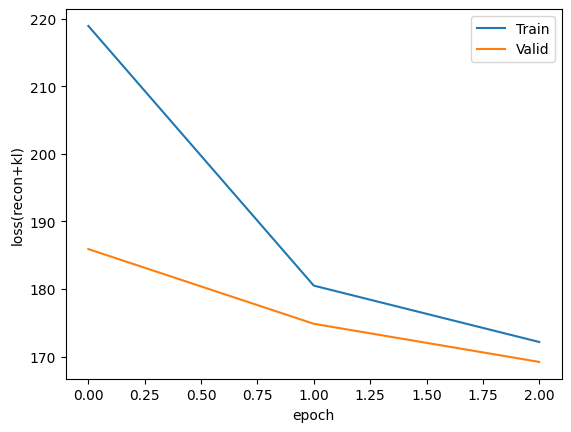

In [6]:
def train_VAE(num_epoch):
    best_loss = 1e9
    best_epoch = 0
    valid_losses = []
    train_losses = []
    for epoch in range(num_epoch):
        start_time = time.time()
        print(f"epoch {epoch+1} start")
        model.train()

        train_loss = 0.
        train_num = len(train_loader.dataset)

        for idx, (x, _) in enumerate(train_loader):
            batch = x.size(0) # 当前处理的batch中的图片数量,因为并不是每个batch都是batch_size
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            recon = recon_loss(recon_x, x)
            kl = kl_loss(mu, logvar)

            loss = recon+kl

            train_loss += loss.item()
            loss = loss / batch

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if idx %100 == 0:
                print(f"Train Loss:{loss:.3f},Recon Loss:{recon/batch:.3f},KL Loss:{kl/batch:.3f} in step {idx}")
            
        train_losses.append(train_loss/train_num)
        
        # 验证
        valid_loss = 0.
        valid_recon = 0.
        valid_kl = 0.
        valid_num = len(test_loader.dataset)
        model.eval()
        with torch.no_grad():
            for idx,(x,_) in enumerate(test_loader):
                x = x.to(device)
                recon_x ,mu,logvar = model(x)
                recon = recon_loss(recon_x ,x)
                kl = kl_loss(mu,logvar)
                
                loss = recon+kl
                valid_loss += loss.item()
                valid_recon += recon.item()
                valid_kl += kl.item()
            valid_losses.append(valid_loss/valid_num)
            
            print(f"Valid Loss:{loss:.3f},Recon Loss:{recon/valid_num:.3f},KL Loss:{kl/valid_num:.3f} in step {idx}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_epoch = epoch
                
                torch.save(model,"model/best_VAE_MNIST_Model.pth")
                torch.save(model.state_dict(), 'model/best_VAE_MNIST_Para')
                print("适用于验证集的最佳模型已保存")
        print(f"epoch:{epoch} finished in {time.time()-start_time:.3f}s")
        

    # len(train_losses),len(valid_losses)
    plt.plot(train_losses,label='Train')
    plt.plot(valid_losses,label='Valid')
    plt.legend(loc='upper right')
    plt.ylabel("loss(recon+kl)")
    plt.xlabel("epoch")
    plt.show()
train_VAE(num_epoch=3)

# 可视化

## 参数量

In [7]:
## 网络参数量
from thop import profile 
flops, params = profile(model.to("cpu"), inputs=(torch.randn(1,784),))
print(flops)
print(params)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
402944.0
404244.0


## 模型可视化
![](img/2022-10-12-15-05-01.png)

In [8]:
## 网络模型可视化
import netron
netron.start("model/best_VAE_MNIST_Model.pth",address=8080,)

Serving 'model/best_VAE_MNIST_Model.pth' at http://localhost:8080


('localhost', 8080)

In [9]:
model = VAE(input_dim,inter_dim,latent_dim)
model.load_state_dict(torch.load("model/best_VAE_MNIST_para"))

<All keys matched successfully>

## VAE图像生成

(-0.5, 559.5, 559.5, -0.5)

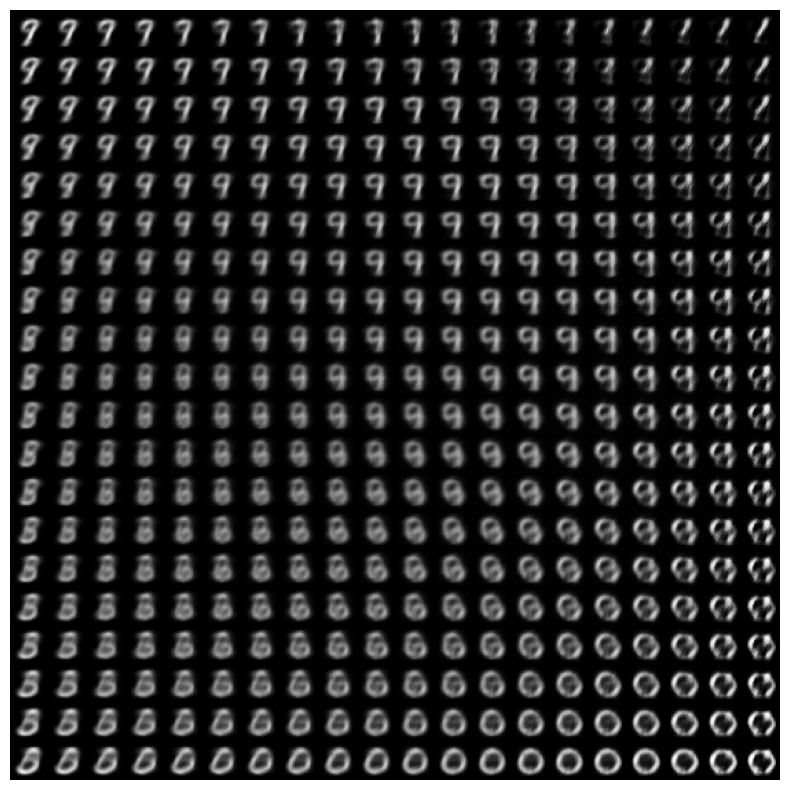

In [10]:
from re import L
import numpy as np
from scipy.stats import norm

n = 20
digit_size = 28 # 单个图像为28*28

grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))

model.eval()
figure = np.zeros((digit_size*n,digit_size*n)) # 单个图像为28*28,整个画布共20*20个图像
for i,yi in enumerate(grid_y):
    for j,xi in enumerate(grid_x):
        z_sampled = torch.FloatTensor([xi,yi])
        with torch.no_grad():
            decoded = model.decoder(z_sampled)
            digit = decoded.view((digit_size,digit_size)) # 将图像转换为28*28
            figure[
                i*digit_size:(i+1)*digit_size,
                j*digit_size:(j+1)*digit_size
                   ]=digit

plt.figure(figsize=(10,10))
plt.imshow(figure,cmap="gray")      
plt.axis("off")